# Regression (Linear)

**Context:** At this point, you have the building blocks for developing many commonly-used ML models. Using these building blocks, we will develop a commonly used ML model---regression. A regression model is a *predictive* model (i.e. a conditional distribution), in which the variable we're interested in predicting is *continuous*. 

**Challenge:** Recall that in a conditional distribution, the parameters of the distribution depend on what we're conditioning. For example, when predicting the probability of intorixaction, $I$, given the day of the week, $D$, we can use a model like,
\begin{align}
p_{I | D}(i | d) = \mathrm{Ber}(\rho(d)) = \underbrace{\rho(d)^{i} \cdot \left(1 - \rho(d) \right)^{1 - i}}_{\text{Bernoulli PMF (see Wikipedia)}},
\end{align}
where the parameter, $\rho(d)$, is a function of the condition (i.e. the day $d$):
\begin{align} \rho(d) &= \begin{cases}
0.1 & \text{if $d$ is weekday} \\
0.4 & \text{if $d$ is weekend}
\end{cases} 
\end{align}
As in this model, in all models we've considered so far, the parameters depend on the condition using if-else expressions (e.g. if $d$ is a weekday, then $\rho = 0.1$, else $\rho = 0.4$). Unfortunately, as models become more complex, this approach for specifying a model becomes unwieldy. For example, if instead of conditioning on something simple, like the day, we instead conditioned on something complicated, like medical image---$1000 \times 1000$ pixels in size---how would we write the appropriate if-else expression? Out of a total of 1-million pixels in the image, which ones are important to even include in the if-else expression? The classes of predictive models we will introduce now---regression and (later) classification---precisely allow us to circumvent this issue. How? By making the parameter a more interesting function of the condition. Continuing with the above example, we can define, $\rho(d)$ as a linear function of $d$:
\begin{align}
\rho(d) &= \mathrm{intercept} + \mathrm{slope} \cdot d.
\end{align}
We can similarly make $\rho(d)$ a quadratic, or sinusoidal, or polynomial function of $d$---there are endless possibilities. Of course, in this example, $d$ can be one of two values, so making $\rho(d)$ some function of $d$ is not helpful---but when $d$ is more complicated, like an image, this trick will be incredibly helpful. We will start with simple, linear functions, and build up to more complex functions (using neural networks).

**Outline:**
* Introduce predictive models generally
* Instantiate a regression model as a specific type of predictive model
* Implement the regression in `NumPyro`
* Understand how to quantify model performance

**Data:** Before diving in, let's familiarize ourself with the data set we'll be working with. This data set comes from a special, interdisciplinary effort at the IHH, spanning two major centers. The first is one you're already familiar with: the Center for Telekinesis Research (CTR), dedicated to the study of telekinesis (the ability of moving physical objects with your mind). The second is the Center for Glow and Positive Life Flow (CGLF). As you know, one of the great mysteries of the galaxy is why intergalactic being glow, and what it can tell us about other aspects of their life. As part of this effort, IHH researchers want to understand how age affects telekinetic ability and glow. They have recruited you to help with the data analysis. 

Let's take a look at the data they sent us:

In [55]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax
import jax.numpy as jnp

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-CGLF-Glow.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

,Age,Glow,Telekinetic-Ability
Patient ID,,,
90,30.607729,60.408516,0.110578
254,38.531357,61.364480,0.049644
283,21.879414,82.921200,0.263387
445,2.949004,98.112000,0.356437
461,30.237446,68.832900,0.097479
15,29.562483,79.685270,0.081543
316,15.283975,83.954630,0.453322
489,2.688488,92.942245,0.383801
159,4.129371,89.381280,0.566650


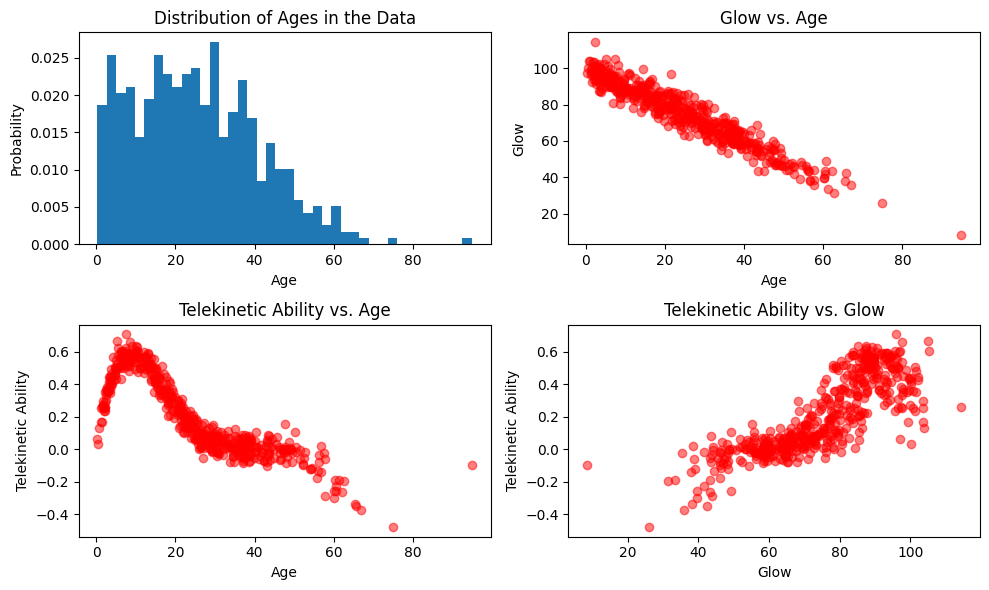

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

axes[0, 0].hist(data['Age'], bins=40, density=True)
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Probability')
axes[0, 0].set_title('Distribution of Ages in the Data')

axes[0, 1].scatter(data['Age'], data['Glow'], color='red', alpha=0.5)
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Glow')
axes[0, 1].set_title('Glow vs. Age')

axes[1, 0].scatter(data['Age'], data['Telekinetic-Ability'], color='red', alpha=0.5)
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Telekinetic Ability')
axes[1, 0].set_title('Telekinetic Ability vs. Age')

axes[1, 1].scatter(data['Glow'], data['Telekinetic-Ability'], color='red', alpha=0.5)
axes[1, 1].set_xlabel('Glow')
axes[1, 1].set_ylabel('Telekinetic Ability')
axes[1, 1].set_title('Telekinetic Ability vs. Glow')

plt.tight_layout()
plt.show()

## Predictive Models

To understand the effects of age on glow and telekinetic ability, we will try to see if there is a relationship between them---if age changes, does glow and telekinetic ability change? To do this, we will fit a predictive model (and more specifically, a regression model) to the data. We will then interpret it and see what we learn. Of course, we have to be cautious about our interpretation of the results: just because glow may change as a function of age *does not* mean that aging *causes* changes in glow---more on that later.

**Approach.** Since regression models are a specific type of predictive model, let's first describe what a predictive model is using the toolkit we've developed so far. Specifically, we'll describe a predictive model using the directed graphical model and its corresponding generative process. Then, we will write down its joint data distribution and MLE objective.

**Directed Graphical Model.** Suppose we have a data set of observations of two RVs: "inputs" $X$ and "outputs" $Y$. Our goal is to learn to predict $Y$ from $X$ (i.e. learn a conditional distribution $p_{Y | X}$). Our graphical model should therefore include the following:
* It should have a node for $X$ and a node for $Y$, representing our two random variables.
* It should have an arrow pointing from $X$ into $Y$ to represent $Y$'s dependence on $X$.
* Since we have many i.i.d observations of $(X, Y)$-pairs, we'll need $X$ and $Y$ in a plate.
* Finally, the we'll probably want the relationship between $X$ and $Y$ to be controlled by some parameter, $\theta$, that can be learned from the data.

A predictive model has the following graphical representation:
<div class="canva-centered-embedding">
  <div class="canva-iframe-container">
    <iframe loading="lazy" class="canva-iframe"
      src="https:&#x2F;&#x2F;www.canva.com&#x2F;design&#x2F;DAGJv58NH1k&#x2F;-MhOv0aEL8dP0kRgjrIN6Q&#x2F;view?embed">
    </iframe>
  </div>
</div>

**Generative Process.** Our graphical model can be directly translated into the following generative process: for $n = 1, \dots, N$,
\begin{align}
x_n &\sim p_X(x_n) \\
y_n | x_n &\sim p_{Y | X}(\cdot | x_n; \theta) 
\end{align}
Notice that we've chosen our marginal over the inputs, $p_X(x_n)$, to *not depend* on any parameters. This is because we *just* care about learning how to predict $Y$ from $X$. That is, we assume our use-case will be that we are *given* specific $x$'s for which we want to make predictions---we therefore don't need to sample them from $p_X(\cdot)$ (or learn $p_X(\cdot)$). As you will see in the derivation of our objective function, $p_X(x_n)$ will not impact our MLE in any way. 

**Joint Data Log-Likelihood.** For the above model, we have the following joint data log-likelihood:
\begin{align}
\log p(\mathcal{D}; \theta) &= \log \prod\limits_{n=1}^N p(\mathcal{D}_n; \theta) \quad (\text{i.i.d observations}) \\
&= \sum\limits_{n=1}^N \log p(\mathcal{D}_n; \theta) \quad (\text{since } \log(a \cdot b) = \log a + \log b) \\
&= \sum\limits_{n=1}^N \log p_{X, Y}(x_n, y_n; \theta) \quad (\text{since } \mathcal{D}_n = (x_n, y_n)) \\
&= \sum\limits_{n=1}^N \log \left( p_{Y | X}(y_n | x_n; \theta) \cdot p_X(x_n) \right) \quad (\text{using our factorization of the joint}) \\
&= \sum\limits_{n=1}^N \log p_{Y | X}(y_n | x_n; \theta) + \log p_X(x_n) \quad (\text{since } \log(a \cdot b) = \log a + \log b) 
\end{align}

**MLE Objective.** Our goal is to maximize the probability of the joint data log-likelihood with respect to parameters $\theta$:
\begin{align}
\mathrm{argmax}_\theta \log p(\mathcal{D}; \theta) &= \mathrm{argmax}_\theta \sum\limits_{n=1}^N \log p_{Y | X}(y_n | x_n; \theta) + \log p_X(x_n) \quad (\text{substituting in our joint data log-likelihood}) \\
&= \mathrm{argmin}_\theta -\sum\limits_{n=1}^N \left( \log p_{Y | X}(y_n | x_n; \theta) + \log p_X(x_n) \right) \quad (\text{taking an argmax is like taking an argmin of the negative}) \\
&= \mathrm{argmin}_\theta -\sum\limits_{n=1}^N \log p_{Y | X}(y_n | x_n; \theta) - \underbrace{\sum\limits_{n=1}^N \log p_X(x_n)}_{\text{does not depend on } \theta} \quad (\text{we split out the sum into two parts}) \\
&= \mathrm{argmin}_\theta -\sum\limits_{n=1}^N \log p_{Y | X}(y_n | x_n; \theta) \quad (\text{term that doesn't depend on $\theta$ doesn't affect argmin}) 
\end{align}
This gives us the following objective (or loss function):
\begin{align}
\mathcal{L}(\theta) = -\sum\limits_{n=1}^N \log p_{Y | X}(y_n | x_n; \theta)
\end{align}
Now that we have our objective, the only thing missing now is a specific choice of $p_{Y | X}(y_n | x_n; \theta)$. We will next select $p_{Y | X}(y_n | x_n; \theta)$ to give us a regression model. Later, we will do the same for other models (e.g. classification). 

## The Regression Model

**The Model.** Looking at our objective function, $\mathcal{L}(\theta)$, the only thing we need to define is $p_{Y | X}(y_n | x_n; \theta)$. Let's introduce a picture to help our intuition for what this distribution should be. Consider the following regression data sets (we want to predict our outputs from our inputs). 

```{figure} _static/figs/example_regression_data.png
---
name: fig-regression-data
align: center
---
Two regression data sets with univariate inputs and outputs.
```
These plots show us that our missing piece, $p_{Y | X}(y_n | x_n; \theta)$, should have two parts. First, it needs some way of accounting for the general "trend" (e.g. on the left, the trend is that as $x$ increases, $y$ also increases). Second, there is some "noise" around this trend. To capture both components, we define our model as follows:
\begin{align}
p_{Y | X}(\cdot | x_n; \underbrace{W, \sigma}_{\theta}) = \mathcal{N}( \underbrace{\mu(x_n; W)}_{\text{trend}}, \underbrace{\sigma^2}_{\text{noise}} ),
\end{align}
where $\theta = \{ W, \sigma \}$, and where $\mu(\cdot; W)$ is a function parameterized by $W$ (which controls its shape). Putting this all together, our generative process says:
1. We're given an input, $x_n$, from our data.
2. We feed it through our function $\mu(\cdot; W)$ to predict what $y_n$ will be, on average. This captures the "trend."
3. Finally, we add some Gaussian noise to the result. This Gaussian noise represents the error in our measurement. For example, our devices that measure height, blood pressure, etc. at the IHH are correct on average, but are always off by some small amount of random noise. How much noise is determining by the variance of the Gaussian, $\sigma^2$.

Let's visualize what this looks like:

```{figure} _static/figs/example_regression.png
---
name: fig-regression-example
align: center
---
Plot of linear (left) and polynomial (right) regression. On the left, $\mu(x_n; W)$ is a linear function of $x_n$. On the right, it is a polynomial function of $x_n$.
```

Here, the blue line, representing $\mu(\cdot; W)$ captures the "trend" of the data. The data (in red) surrounds the trend; it lies around it due to the observation error (or noise).

## Choosing a Functional Form 

So what is $\mu(\cdot; W)$ exactly? For now we will start simple, but a bit later in the course, we will build up to very fancy models, in which $\mu$ is represented by an expressive model, like a neural network. So let's pick $\mu(\cdot; W)$ to be a linear function (i.e. a line with a slope and intercept).

Let our inputs, $x_n$, be $D$-dimensional. We access the $d$-th dimension of $x_n$ using the notation, $x_n^{(d)}$. For example $x_n^{(1)}$ can represent the patient's height, $x_n^{(2)}$ can represent the patient's blood pressure, etc. We then define $\mu(\cdot; W)$ as follows:
\begin{align}
\mu(x_n; W) &= W^{(0)} + W^{(1)} \cdot x_n^{(1)} + W^{(2)} \cdot x_n^{(2)} + \dots + W^{(D)} \cdot x_n^{(D)} \\
&= W^{(0)} + \sum\limits_{d=1}^D W^{(d)} \cdot x_n^{(d)}
\end{align}
Here, $W$ has $D + 1$ dimensions; $W^{(0)}$ is the intercept, and $W^{(1)}, \dots, W^{(D)}$ are the slopes.